<a href="https://colab.research.google.com/github/prashantiyaramareddy/MyPython-Stuff/blob/master/Pytorch/Pytorch_Image_Transformer_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. Pytorch paper - Vision Transformer



## 0. Get Setup


In [2]:
# For notebook to run with updated API's, we need torch 1.12+ and torchvision 0.13+
try:
  import torch
  import torchvision
  assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
  assert int(torchvision.__version__.split(".")[0]) >= 13, "torchvision version should be 0.13+"
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")
except:
  print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
  !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
  import torch
  import torchvision
  print(f"torch version: {torch.__version__}")
  print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://download.pytorch.org/whl/cu118
torch version: 2.8.0+cu126
torchvision version: 0.23.0+cu126


In [5]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it does not work
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

# Try to import the going_modular directory, download it from github if it does not work
try:
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  # Get the going modular scripts
  print("[INFO] Couldn't find going_modular or helperfunctions scripts... downloading them from github.")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py .
  !rm -rf pytorch-deep_learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helperfunctions scripts... downloading them from github.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Total 4393 (delta 0), reused 0 (delta 0), pack-reused 4393 (from 1)
Receiving objects: 100% (4393/4393), 764.14 MiB | 15.30 MiB/s, done.
Resolving deltas: 100% (2657/2657), done.
Updating files: 100% (248/248), done.


### 1. Get Data

In [6]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [8]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [9]:
### 2. Create Datasets and DataLoaders

## 2.1 Prepare transforms for images
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [10]:
## 2.2 Turn image into DataLoader's
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7dc76a87e8d0>,
 ['pizza', 'steak', 'sushi'])

In [11]:
## 2.3 Visualize a single image

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

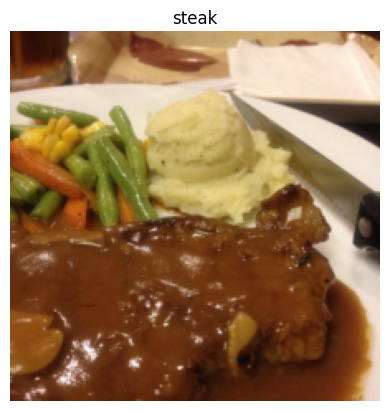

In [12]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

### 4.1 Calculate patch embedding input and output shapes


In [13]:
height = 224
width  = 224
color_channels = 3
patch_size = 16

# Calculate N (number of patches)
number_of_patches = (height * width) / (patch_size * patch_size)
print(f"Number of patches: {number_of_patches}")

Number of patches: 196.0


* Input: The image starts as 2D with size ${H \times W \times C}$.
* Output: The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.

In [14]:
# Input Shape ( this is the size of single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output Shape
embedding_layer_output_shape = (number_of_patches, patch_size * patch_size * color_channels)

embedding_layer_input_shape, embedding_layer_output_shape

((224, 224, 3), (196.0, 768))